<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[03:09:14] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


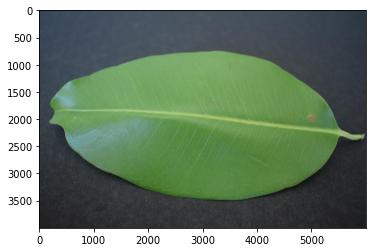

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

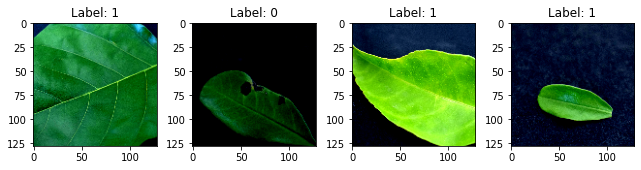

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[03:09:20] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[03:09:22] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2271895234752108 samples/sec                   batch loss = 2.262289524078369 | accuracy = 0.25


Epoch[1] Batch[10] Speed: 1.2570674762385687 samples/sec                   batch loss = 0.3816293776035309 | accuracy = 0.4


Epoch[1] Batch[15] Speed: 1.2625733437526716 samples/sec                   batch loss = 0.7107931971549988 | accuracy = 0.4666666666666667


Epoch[1] Batch[20] Speed: 1.2602290226624224 samples/sec                   batch loss = 1.0901024341583252 | accuracy = 0.5125


Epoch[1] Batch[25] Speed: 1.2655811690102035 samples/sec                   batch loss = 0.4402879476547241 | accuracy = 0.53


Epoch[1] Batch[30] Speed: 1.2638329812394369 samples/sec                   batch loss = 0.8457258939743042 | accuracy = 0.5416666666666666


Epoch[1] Batch[35] Speed: 1.2670337646519425 samples/sec                   batch loss = 0.26557600498199463 | accuracy = 0.5571428571428572


Epoch[1] Batch[40] Speed: 1.2652449228336475 samples/sec                   batch loss = 0.7210586071014404 | accuracy = 0.55


Epoch[1] Batch[45] Speed: 1.257859534054401 samples/sec                   batch loss = 0.6519673466682434 | accuracy = 0.5611111111111111


Epoch[1] Batch[50] Speed: 1.2571180574288074 samples/sec                   batch loss = 0.577164888381958 | accuracy = 0.58


Epoch[1] Batch[55] Speed: 1.2618565757547953 samples/sec                   batch loss = 1.1566643714904785 | accuracy = 0.5818181818181818


Epoch[1] Batch[60] Speed: 1.260125564784657 samples/sec                   batch loss = 0.5737537741661072 | accuracy = 0.5791666666666667


Epoch[1] Batch[65] Speed: 1.2575100347664032 samples/sec                   batch loss = 1.3306469917297363 | accuracy = 0.5692307692307692


Epoch[1] Batch[70] Speed: 1.260619248597347 samples/sec                   batch loss = 0.6409221887588501 | accuracy = 0.575


Epoch[1] Batch[75] Speed: 1.258868013323705 samples/sec                   batch loss = 0.8427712917327881 | accuracy = 0.5633333333333334


Epoch[1] Batch[80] Speed: 1.2600488105846643 samples/sec                   batch loss = 0.5147362947463989 | accuracy = 0.575


Epoch[1] Batch[85] Speed: 1.2542344726657482 samples/sec                   batch loss = 0.34645357728004456 | accuracy = 0.5617647058823529


Epoch[1] Batch[90] Speed: 1.2580812891369075 samples/sec                   batch loss = 0.6115157604217529 | accuracy = 0.5722222222222222


Epoch[1] Batch[95] Speed: 1.2613758631389096 samples/sec                   batch loss = 0.36204615235328674 | accuracy = 0.5736842105263158


Epoch[1] Batch[100] Speed: 1.2644568814223476 samples/sec                   batch loss = 0.2628636658191681 | accuracy = 0.58


Epoch[1] Batch[105] Speed: 1.2632962534264502 samples/sec                   batch loss = 0.8957194089889526 | accuracy = 0.5857142857142857


Epoch[1] Batch[110] Speed: 1.2618580942750874 samples/sec                   batch loss = 0.7567734718322754 | accuracy = 0.5772727272727273


Epoch[1] Batch[115] Speed: 1.2608254907570589 samples/sec                   batch loss = 0.5414764285087585 | accuracy = 0.5739130434782609


Epoch[1] Batch[120] Speed: 1.264368069031784 samples/sec                   batch loss = 0.772997260093689 | accuracy = 0.575


Epoch[1] Batch[125] Speed: 1.2568529517459932 samples/sec                   batch loss = 0.7715917229652405 | accuracy = 0.578


Epoch[1] Batch[130] Speed: 1.2611159736694222 samples/sec                   batch loss = 0.6705194115638733 | accuracy = 0.5769230769230769


Epoch[1] Batch[135] Speed: 1.2590232275800957 samples/sec                   batch loss = 1.216120958328247 | accuracy = 0.5833333333333334


Epoch[1] Batch[140] Speed: 1.259376026509235 samples/sec                   batch loss = 1.5101889371871948 | accuracy = 0.5875


Epoch[1] Batch[145] Speed: 1.2563319189640776 samples/sec                   batch loss = 0.6718438863754272 | accuracy = 0.5913793103448276


Epoch[1] Batch[150] Speed: 1.2693899523748453 samples/sec                   batch loss = 0.43857207894325256 | accuracy = 0.5883333333333334


Epoch[1] Batch[155] Speed: 1.2706758420949786 samples/sec                   batch loss = 0.8745120763778687 | accuracy = 0.5870967741935483


Epoch[1] Batch[160] Speed: 1.2618179496237496 samples/sec                   batch loss = 0.5360651612281799 | accuracy = 0.590625


Epoch[1] Batch[165] Speed: 1.258955487863171 samples/sec                   batch loss = 0.49210816621780396 | accuracy = 0.5969696969696969


Epoch[1] Batch[170] Speed: 1.2714191430046589 samples/sec                   batch loss = 0.6227434277534485 | accuracy = 0.6029411764705882


Epoch[1] Batch[175] Speed: 1.2690165471515609 samples/sec                   batch loss = 0.7581464052200317 | accuracy = 0.6071428571428571


Epoch[1] Batch[180] Speed: 1.2580320453986478 samples/sec                   batch loss = 0.3754492700099945 | accuracy = 0.6083333333333333


Epoch[1] Batch[185] Speed: 1.2643313851511364 samples/sec                   batch loss = 0.584333062171936 | accuracy = 0.6108108108108108


Epoch[1] Batch[190] Speed: 1.2610937917881804 samples/sec                   batch loss = 0.5936176776885986 | accuracy = 0.6092105263157894


Epoch[1] Batch[195] Speed: 1.2617965022281021 samples/sec                   batch loss = 0.5164989829063416 | accuracy = 0.6128205128205129


Epoch[1] Batch[200] Speed: 1.2576717023612094 samples/sec                   batch loss = 0.6814222931861877 | accuracy = 0.61375


Epoch[1] Batch[205] Speed: 1.2626607638393423 samples/sec                   batch loss = 0.6336044073104858 | accuracy = 0.6121951219512195


Epoch[1] Batch[210] Speed: 1.2597915487449778 samples/sec                   batch loss = 0.3115207254886627 | accuracy = 0.6130952380952381


Epoch[1] Batch[215] Speed: 1.2597035796535074 samples/sec                   batch loss = 0.45575374364852905 | accuracy = 0.6162790697674418


Epoch[1] Batch[220] Speed: 1.2627155025779326 samples/sec                   batch loss = 0.46787771582603455 | accuracy = 0.6136363636363636


Epoch[1] Batch[225] Speed: 1.2663941278474724 samples/sec                   batch loss = 0.2917407751083374 | accuracy = 0.6166666666666667


Epoch[1] Batch[230] Speed: 1.2600935748447792 samples/sec                   batch loss = 0.9043974876403809 | accuracy = 0.6173913043478261


Epoch[1] Batch[235] Speed: 1.2650033711374238 samples/sec                   batch loss = 0.8125937581062317 | accuracy = 0.6223404255319149


Epoch[1] Batch[240] Speed: 1.2623301515529086 samples/sec                   batch loss = 0.5618614554405212 | accuracy = 0.6239583333333333


Epoch[1] Batch[245] Speed: 1.2597380091034553 samples/sec                   batch loss = 0.26278072595596313 | accuracy = 0.6265306122448979


Epoch[1] Batch[250] Speed: 1.2623610203706495 samples/sec                   batch loss = 0.6594020128250122 | accuracy = 0.626


Epoch[1] Batch[255] Speed: 1.2644730824528034 samples/sec                   batch loss = 0.7316373586654663 | accuracy = 0.6284313725490196


Epoch[1] Batch[260] Speed: 1.2611446027208861 samples/sec                   batch loss = 0.6374179124832153 | accuracy = 0.6259615384615385


Epoch[1] Batch[265] Speed: 1.2713391764522857 samples/sec                   batch loss = 0.4386487603187561 | accuracy = 0.6283018867924528


Epoch[1] Batch[270] Speed: 1.267389918967258 samples/sec                   batch loss = 0.6557844877243042 | accuracy = 0.6296296296296297


Epoch[1] Batch[275] Speed: 1.2632843630269732 samples/sec                   batch loss = 0.654589056968689 | accuracy = 0.6290909090909091


Epoch[1] Batch[280] Speed: 1.259895992520473 samples/sec                   batch loss = 0.7135748267173767 | accuracy = 0.6267857142857143


Epoch[1] Batch[285] Speed: 1.2649569221250612 samples/sec                   batch loss = 0.22993120551109314 | accuracy = 0.6324561403508772


Epoch[1] Batch[290] Speed: 1.2663564660376354 samples/sec                   batch loss = 0.7854876518249512 | accuracy = 0.628448275862069


Epoch[1] Batch[295] Speed: 1.2615784634627834 samples/sec                   batch loss = 0.6373425722122192 | accuracy = 0.6305084745762712


Epoch[1] Batch[300] Speed: 1.2679890656717976 samples/sec                   batch loss = 0.46283647418022156 | accuracy = 0.6325


Epoch[1] Batch[305] Speed: 1.2588661241589034 samples/sec                   batch loss = 0.6332144141197205 | accuracy = 0.6336065573770492


Epoch[1] Batch[310] Speed: 1.2750567619811954 samples/sec                   batch loss = 0.7633875012397766 | accuracy = 0.6362903225806451


Epoch[1] Batch[315] Speed: 1.267401695291305 samples/sec                   batch loss = 0.6620746850967407 | accuracy = 0.6349206349206349


Epoch[1] Batch[320] Speed: 1.270837832439269 samples/sec                   batch loss = 0.33778417110443115 | accuracy = 0.6359375


Epoch[1] Batch[325] Speed: 1.2695468115996205 samples/sec                   batch loss = 0.5466268062591553 | accuracy = 0.6353846153846154


Epoch[1] Batch[330] Speed: 1.2652953054279616 samples/sec                   batch loss = 0.42616578936576843 | accuracy = 0.634090909090909


Epoch[1] Batch[335] Speed: 1.2662020186971639 samples/sec                   batch loss = 0.9904251098632812 | accuracy = 0.6313432835820896


Epoch[1] Batch[340] Speed: 1.2692941077049935 samples/sec                   batch loss = 0.6087165474891663 | accuracy = 0.6316176470588235


Epoch[1] Batch[345] Speed: 1.2643563490151344 samples/sec                   batch loss = 0.34043705463409424 | accuracy = 0.6326086956521739


Epoch[1] Batch[350] Speed: 1.2631747916413343 samples/sec                   batch loss = 0.5804365277290344 | accuracy = 0.6335714285714286


Epoch[1] Batch[355] Speed: 1.2675926363162089 samples/sec                   batch loss = 0.38565894961357117 | accuracy = 0.6345070422535212


Epoch[1] Batch[360] Speed: 1.2637205542100665 samples/sec                   batch loss = 0.48611366748809814 | accuracy = 0.6354166666666666


Epoch[1] Batch[365] Speed: 1.26121513811545 samples/sec                   batch loss = 0.5788248181343079 | accuracy = 0.6342465753424658


Epoch[1] Batch[370] Speed: 1.266077608946964 samples/sec                   batch loss = 0.8192133903503418 | accuracy = 0.6337837837837837


Epoch[1] Batch[375] Speed: 1.2677348740102206 samples/sec                   batch loss = 0.6068500280380249 | accuracy = 0.6333333333333333


Epoch[1] Batch[380] Speed: 1.2725575886144387 samples/sec                   batch loss = 0.48032164573669434 | accuracy = 0.6322368421052632


Epoch[1] Batch[385] Speed: 1.2721185562531212 samples/sec                   batch loss = 0.5314292907714844 | accuracy = 0.6331168831168831


Epoch[1] Batch[390] Speed: 1.2679563877591522 samples/sec                   batch loss = 0.3900459408760071 | accuracy = 0.6365384615384615


Epoch[1] Batch[395] Speed: 1.2651064867826087 samples/sec                   batch loss = 1.1007063388824463 | accuracy = 0.6335443037974684


Epoch[1] Batch[400] Speed: 1.2651559997122386 samples/sec                   batch loss = 0.4798537790775299 | accuracy = 0.634375


Epoch[1] Batch[405] Speed: 1.2614637814102467 samples/sec                   batch loss = 0.4110372066497803 | accuracy = 0.6345679012345679


Epoch[1] Batch[410] Speed: 1.2668185993789294 samples/sec                   batch loss = 0.48940902948379517 | accuracy = 0.6371951219512195


Epoch[1] Batch[415] Speed: 1.2686754033268859 samples/sec                   batch loss = 0.7205338478088379 | accuracy = 0.6355421686746988


Epoch[1] Batch[420] Speed: 1.260912668961588 samples/sec                   batch loss = 0.7199564576148987 | accuracy = 0.6333333333333333


Epoch[1] Batch[425] Speed: 1.2659943005711125 samples/sec                   batch loss = 0.3441077172756195 | accuracy = 0.6347058823529412


Epoch[1] Batch[430] Speed: 1.2752706637251014 samples/sec                   batch loss = 0.46255481243133545 | accuracy = 0.6337209302325582


Epoch[1] Batch[435] Speed: 1.2771303736393698 samples/sec                   batch loss = 0.7703626155853271 | accuracy = 0.6339080459770114


Epoch[1] Batch[440] Speed: 1.2652039899300802 samples/sec                   batch loss = 0.7228805422782898 | accuracy = 0.6346590909090909


Epoch[1] Batch[445] Speed: 1.267245078507832 samples/sec                   batch loss = 0.5430285334587097 | accuracy = 0.6359550561797753


Epoch[1] Batch[450] Speed: 1.2665248144927768 samples/sec                   batch loss = 0.5200645327568054 | accuracy = 0.6361111111111111


Epoch[1] Batch[455] Speed: 1.264410472533133 samples/sec                   batch loss = 0.41544586420059204 | accuracy = 0.6368131868131868


Epoch[1] Batch[460] Speed: 1.26860144106187 samples/sec                   batch loss = 0.7710973620414734 | accuracy = 0.6369565217391304


Epoch[1] Batch[465] Speed: 1.2649035147459222 samples/sec                   batch loss = 0.3154829442501068 | accuracy = 0.6387096774193548


Epoch[1] Batch[470] Speed: 1.2666257876767815 samples/sec                   batch loss = 0.3346312344074249 | accuracy = 0.6398936170212766


Epoch[1] Batch[475] Speed: 1.2599566421885608 samples/sec                   batch loss = 0.7234533429145813 | accuracy = 0.6421052631578947


Epoch[1] Batch[480] Speed: 1.2753686734960639 samples/sec                   batch loss = 0.45370930433273315 | accuracy = 0.6432291666666666


Epoch[1] Batch[485] Speed: 1.2725759284253713 samples/sec                   batch loss = 0.26768237352371216 | accuracy = 0.6458762886597939


Epoch[1] Batch[490] Speed: 1.2697953874862016 samples/sec                   batch loss = 0.8691646456718445 | accuracy = 0.6469387755102041


Epoch[1] Batch[495] Speed: 1.271430994325506 samples/sec                   batch loss = 0.3888661563396454 | accuracy = 0.6484848484848484


Epoch[1] Batch[500] Speed: 1.27507701511939 samples/sec                   batch loss = 1.058179259300232 | accuracy = 0.649


Epoch[1] Batch[505] Speed: 1.27077988462464 samples/sec                   batch loss = 0.1991695761680603 | accuracy = 0.6485148514851485


Epoch[1] Batch[510] Speed: 1.2661412440596387 samples/sec                   batch loss = 0.359588086605072 | accuracy = 0.6495098039215687


Epoch[1] Batch[515] Speed: 1.2753347416034195 samples/sec                   batch loss = 0.7606661915779114 | accuracy = 0.65


Epoch[1] Batch[520] Speed: 1.2681156725499463 samples/sec                   batch loss = 0.31080618500709534 | accuracy = 0.6524038461538462


Epoch[1] Batch[525] Speed: 1.272025192401095 samples/sec                   batch loss = 0.47538432478904724 | accuracy = 0.6542857142857142


Epoch[1] Batch[530] Speed: 1.260236027743915 samples/sec                   batch loss = 0.781643807888031 | accuracy = 0.6537735849056604


Epoch[1] Batch[535] Speed: 1.2697442614950791 samples/sec                   batch loss = 0.5687683820724487 | accuracy = 0.652803738317757


Epoch[1] Batch[540] Speed: 1.270182714078337 samples/sec                   batch loss = 0.7269828915596008 | accuracy = 0.6537037037037037


Epoch[1] Batch[545] Speed: 1.2671515672613398 samples/sec                   batch loss = 0.6245521903038025 | accuracy = 0.6545871559633027


Epoch[1] Batch[550] Speed: 1.2643769306520376 samples/sec                   batch loss = 0.41657915711402893 | accuracy = 0.6559090909090909


Epoch[1] Batch[555] Speed: 1.2662782819201686 samples/sec                   batch loss = 0.2880747616291046 | accuracy = 0.6567567567567567


Epoch[1] Batch[560] Speed: 1.2697794341974438 samples/sec                   batch loss = 0.8176373243331909 | accuracy = 0.6571428571428571


Epoch[1] Batch[565] Speed: 1.260947827931277 samples/sec                   batch loss = 0.6469910740852356 | accuracy = 0.6570796460176991


Epoch[1] Batch[570] Speed: 1.257027070726324 samples/sec                   batch loss = 0.4075213074684143 | accuracy = 0.6583333333333333


Epoch[1] Batch[575] Speed: 1.2662671954674904 samples/sec                   batch loss = 1.2731001377105713 | accuracy = 0.6591304347826087


Epoch[1] Batch[580] Speed: 1.2755265290060518 samples/sec                   batch loss = 0.7833955883979797 | accuracy = 0.6586206896551724


Epoch[1] Batch[585] Speed: 1.264857263784897 samples/sec                   batch loss = 0.4105139672756195 | accuracy = 0.6576923076923077


Epoch[1] Batch[590] Speed: 1.2620199325421908 samples/sec                   batch loss = 0.5483945608139038 | accuracy = 0.6584745762711864


Epoch[1] Batch[595] Speed: 1.2605725526915474 samples/sec                   batch loss = 0.6505504250526428 | accuracy = 0.6584033613445378


Epoch[1] Batch[600] Speed: 1.266475576781726 samples/sec                   batch loss = 0.6655724048614502 | accuracy = 0.65875


Epoch[1] Batch[605] Speed: 1.2691452794447635 samples/sec                   batch loss = 0.9426458477973938 | accuracy = 0.6578512396694215


Epoch[1] Batch[610] Speed: 1.2697434927146027 samples/sec                   batch loss = 0.8404500484466553 | accuracy = 0.6581967213114754


Epoch[1] Batch[615] Speed: 1.2613321456699957 samples/sec                   batch loss = 0.7225083112716675 | accuracy = 0.658130081300813


Epoch[1] Batch[620] Speed: 1.2721569474328496 samples/sec                   batch loss = 0.5159038305282593 | accuracy = 0.6588709677419354


Epoch[1] Batch[625] Speed: 1.262411078554864 samples/sec                   batch loss = 0.47812557220458984 | accuracy = 0.6592


Epoch[1] Batch[630] Speed: 1.2643535857908292 samples/sec                   batch loss = 0.747711718082428 | accuracy = 0.6595238095238095


Epoch[1] Batch[635] Speed: 1.2640330384764533 samples/sec                   batch loss = 0.4244006872177124 | accuracy = 0.6610236220472441


Epoch[1] Batch[640] Speed: 1.263456367562642 samples/sec                   batch loss = 0.5304478406906128 | accuracy = 0.6609375


Epoch[1] Batch[645] Speed: 1.2643398651317836 samples/sec                   batch loss = 0.7903801202774048 | accuracy = 0.6616279069767442


Epoch[1] Batch[650] Speed: 1.2640610382104376 samples/sec                   batch loss = 0.39876383543014526 | accuracy = 0.661923076923077


Epoch[1] Batch[655] Speed: 1.2673823554273929 samples/sec                   batch loss = 1.4022138118743896 | accuracy = 0.6614503816793893


Epoch[1] Batch[660] Speed: 1.2669289951963492 samples/sec                   batch loss = 0.7707929015159607 | accuracy = 0.6602272727272728


Epoch[1] Batch[665] Speed: 1.2639823754441153 samples/sec                   batch loss = 0.910007655620575 | accuracy = 0.6590225563909774


Epoch[1] Batch[670] Speed: 1.2671702301232177 samples/sec                   batch loss = 0.25017106533050537 | accuracy = 0.6600746268656716


Epoch[1] Batch[675] Speed: 1.2625728686765778 samples/sec                   batch loss = 0.2621895670890808 | accuracy = 0.6603703703703704


Epoch[1] Batch[680] Speed: 1.2660494242669655 samples/sec                   batch loss = 0.2799055278301239 | accuracy = 0.6599264705882353


Epoch[1] Batch[685] Speed: 1.262334900503528 samples/sec                   batch loss = 0.5097923874855042 | accuracy = 0.6598540145985401


Epoch[1] Batch[690] Speed: 1.257748167228799 samples/sec                   batch loss = 0.14319011569023132 | accuracy = 0.6608695652173913


Epoch[1] Batch[695] Speed: 1.260537888191571 samples/sec                   batch loss = 0.2500453591346741 | accuracy = 0.6622302158273381


Epoch[1] Batch[700] Speed: 1.2627300433531483 samples/sec                   batch loss = 0.6865023970603943 | accuracy = 0.6628571428571428


Epoch[1] Batch[705] Speed: 1.2639500941640867 samples/sec                   batch loss = 1.0296592712402344 | accuracy = 0.6627659574468086


Epoch[1] Batch[710] Speed: 1.269576209006618 samples/sec                   batch loss = 0.6448134779930115 | accuracy = 0.6633802816901408


Epoch[1] Batch[715] Speed: 1.2550183631126748 samples/sec                   batch loss = 0.5160171389579773 | accuracy = 0.6643356643356644


Epoch[1] Batch[720] Speed: 1.2598851121525119 samples/sec                   batch loss = 0.5031771063804626 | accuracy = 0.665625


Epoch[1] Batch[725] Speed: 1.260768168181618 samples/sec                   batch loss = 0.2604145407676697 | accuracy = 0.666896551724138


Epoch[1] Batch[730] Speed: 1.2591328358658136 samples/sec                   batch loss = 0.3413957357406616 | accuracy = 0.6674657534246575


Epoch[1] Batch[735] Speed: 1.2581751647954267 samples/sec                   batch loss = 0.9709161520004272 | accuracy = 0.6666666666666666


Epoch[1] Batch[740] Speed: 1.2597969407985659 samples/sec                   batch loss = 0.642426609992981 | accuracy = 0.6672297297297297


Epoch[1] Batch[745] Speed: 1.2591334973530544 samples/sec                   batch loss = 0.7093297839164734 | accuracy = 0.6667785234899329


Epoch[1] Batch[750] Speed: 1.264780408843654 samples/sec                   batch loss = 0.4980052411556244 | accuracy = 0.6676666666666666


Epoch[1] Batch[755] Speed: 1.2493571407880104 samples/sec                   batch loss = 0.4603460431098938 | accuracy = 0.6685430463576159


Epoch[1] Batch[760] Speed: 1.2689801689324647 samples/sec                   batch loss = 0.23607096076011658 | accuracy = 0.6697368421052632


Epoch[1] Batch[765] Speed: 1.2685881076670142 samples/sec                   batch loss = 0.8192929625511169 | accuracy = 0.6709150326797385


Epoch[1] Batch[770] Speed: 1.2722955801019082 samples/sec                   batch loss = 0.2250334918498993 | accuracy = 0.6717532467532468


Epoch[1] Batch[775] Speed: 1.263162332904379 samples/sec                   batch loss = 0.3325481712818146 | accuracy = 0.672258064516129


Epoch[1] Batch[780] Speed: 1.2710924996734614 samples/sec                   batch loss = 0.39746037125587463 | accuracy = 0.6730769230769231


Epoch[1] Batch[785] Speed: 1.2672455571065147 samples/sec                   batch loss = 0.6307168006896973 | accuracy = 0.6735668789808917


[Epoch 1] training: accuracy=0.6735406091370558
[Epoch 1] time cost: 649.248961687088
[Epoch 1] validation: validation accuracy=0.7344444444444445


Epoch[2] Batch[5] Speed: 1.261840821322421 samples/sec                   batch loss = 0.30362921953201294 | accuracy = 0.8


Epoch[2] Batch[10] Speed: 1.2571829617896084 samples/sec                   batch loss = 0.3979858458042145 | accuracy = 0.85


Epoch[2] Batch[15] Speed: 1.2585750716074011 samples/sec                   batch loss = 0.2467966377735138 | accuracy = 0.8333333333333334


Epoch[2] Batch[20] Speed: 1.2656389300905875 samples/sec                   batch loss = 0.6392346620559692 | accuracy = 0.8125


Epoch[2] Batch[25] Speed: 1.264680206317289 samples/sec                   batch loss = 0.27476632595062256 | accuracy = 0.81


Epoch[2] Batch[30] Speed: 1.271735928650901 samples/sec                   batch loss = 0.5289890170097351 | accuracy = 0.7833333333333333


Epoch[2] Batch[35] Speed: 1.261988605766891 samples/sec                   batch loss = 0.36815235018730164 | accuracy = 0.7857142857142857


Epoch[2] Batch[40] Speed: 1.260264616856921 samples/sec                   batch loss = 0.4884594976902008 | accuracy = 0.7875


Epoch[2] Batch[45] Speed: 1.2587886732836817 samples/sec                   batch loss = 0.49008214473724365 | accuracy = 0.7722222222222223


Epoch[2] Batch[50] Speed: 1.265339775217851 samples/sec                   batch loss = 0.6106037497520447 | accuracy = 0.75


Epoch[2] Batch[55] Speed: 1.2637193167672762 samples/sec                   batch loss = 0.4330505132675171 | accuracy = 0.759090909090909


Epoch[2] Batch[60] Speed: 1.261898431308277 samples/sec                   batch loss = 0.26970601081848145 | accuracy = 0.7625


Epoch[2] Batch[65] Speed: 1.2546089853584224 samples/sec                   batch loss = 0.7280134558677673 | accuracy = 0.7615384615384615


Epoch[2] Batch[70] Speed: 1.2568018269949197 samples/sec                   batch loss = 0.2489277869462967 | accuracy = 0.7642857142857142


Epoch[2] Batch[75] Speed: 1.258162993190994 samples/sec                   batch loss = 0.6834911108016968 | accuracy = 0.76


Epoch[2] Batch[80] Speed: 1.2643597792414196 samples/sec                   batch loss = 0.5985478758811951 | accuracy = 0.753125


Epoch[2] Batch[85] Speed: 1.2564690058243033 samples/sec                   batch loss = 1.2933343648910522 | accuracy = 0.7529411764705882


Epoch[2] Batch[90] Speed: 1.260264332852731 samples/sec                   batch loss = 0.07464390248060226 | accuracy = 0.75


Epoch[2] Batch[95] Speed: 1.2669512871544333 samples/sec                   batch loss = 0.4854549467563629 | accuracy = 0.7552631578947369


Epoch[2] Batch[100] Speed: 1.2753600449293137 samples/sec                   batch loss = 0.4152759909629822 | accuracy = 0.765


Epoch[2] Batch[105] Speed: 1.262342213957366 samples/sec                   batch loss = 0.292416512966156 | accuracy = 0.7690476190476191


Epoch[2] Batch[110] Speed: 1.2674467920191692 samples/sec                   batch loss = 0.5308753848075867 | accuracy = 0.7704545454545455


Epoch[2] Batch[115] Speed: 1.2674690064491485 samples/sec                   batch loss = 0.34480759501457214 | accuracy = 0.7739130434782608


Epoch[2] Batch[120] Speed: 1.2700818460576453 samples/sec                   batch loss = 0.19217944145202637 | accuracy = 0.7770833333333333


Epoch[2] Batch[125] Speed: 1.2655085216498212 samples/sec                   batch loss = 0.27516159415245056 | accuracy = 0.778


Epoch[2] Batch[130] Speed: 1.2639332399916678 samples/sec                   batch loss = 1.3732868432998657 | accuracy = 0.7788461538461539


Epoch[2] Batch[135] Speed: 1.268843793174696 samples/sec                   batch loss = 1.4093866348266602 | accuracy = 0.774074074074074


Epoch[2] Batch[140] Speed: 1.2719613502192109 samples/sec                   batch loss = 0.35784268379211426 | accuracy = 0.775


Epoch[2] Batch[145] Speed: 1.2652901524784346 samples/sec                   batch loss = 0.5151446461677551 | accuracy = 0.7775862068965518


Epoch[2] Batch[150] Speed: 1.2561696550695531 samples/sec                   batch loss = 0.2476634979248047 | accuracy = 0.775


Epoch[2] Batch[155] Speed: 1.2632849337610341 samples/sec                   batch loss = 0.6818373799324036 | accuracy = 0.7741935483870968


Epoch[2] Batch[160] Speed: 1.2660217185165197 samples/sec                   batch loss = 0.6960147619247437 | accuracy = 0.775


Epoch[2] Batch[165] Speed: 1.2643474876833778 samples/sec                   batch loss = 0.4524528682231903 | accuracy = 0.7712121212121212


Epoch[2] Batch[170] Speed: 1.2605562620333413 samples/sec                   batch loss = 0.2988617420196533 | accuracy = 0.7720588235294118


Epoch[2] Batch[175] Speed: 1.2656397893861284 samples/sec                   batch loss = 0.42759209871292114 | accuracy = 0.7742857142857142


Epoch[2] Batch[180] Speed: 1.2664231882368864 samples/sec                   batch loss = 0.4017864167690277 | accuracy = 0.7736111111111111


Epoch[2] Batch[185] Speed: 1.264747038018212 samples/sec                   batch loss = 1.0121808052062988 | accuracy = 0.7743243243243243


Epoch[2] Batch[190] Speed: 1.2643575877058124 samples/sec                   batch loss = 0.28092941641807556 | accuracy = 0.7776315789473685


Epoch[2] Batch[195] Speed: 1.263717793764092 samples/sec                   batch loss = 0.22341936826705933 | accuracy = 0.782051282051282


Epoch[2] Batch[200] Speed: 1.2617438358323716 samples/sec                   batch loss = 0.9628303647041321 | accuracy = 0.77875


Epoch[2] Batch[205] Speed: 1.2592180789474612 samples/sec                   batch loss = 0.629838764667511 | accuracy = 0.7780487804878049


Epoch[2] Batch[210] Speed: 1.2673446348168937 samples/sec                   batch loss = 0.3270881474018097 | accuracy = 0.7785714285714286


Epoch[2] Batch[215] Speed: 1.2649708469329584 samples/sec                   batch loss = 0.5665426254272461 | accuracy = 0.7767441860465116


Epoch[2] Batch[220] Speed: 1.260000264358576 samples/sec                   batch loss = 0.419696569442749 | accuracy = 0.7784090909090909


Epoch[2] Batch[225] Speed: 1.2617157488856254 samples/sec                   batch loss = 1.5694139003753662 | accuracy = 0.7766666666666666


Epoch[2] Batch[230] Speed: 1.2685995225705275 samples/sec                   batch loss = 0.5860092639923096 | accuracy = 0.7771739130434783


Epoch[2] Batch[235] Speed: 1.261110285933175 samples/sec                   batch loss = 0.7704391479492188 | accuracy = 0.7776595744680851


Epoch[2] Batch[240] Speed: 1.262766919500304 samples/sec                   batch loss = 0.2442011833190918 | accuracy = 0.7770833333333333


Epoch[2] Batch[245] Speed: 1.2684508571402648 samples/sec                   batch loss = 0.6813279390335083 | accuracy = 0.7775510204081633


Epoch[2] Batch[250] Speed: 1.261910295632359 samples/sec                   batch loss = 0.9827303290367126 | accuracy = 0.777


Epoch[2] Batch[255] Speed: 1.268510798685762 samples/sec                   batch loss = 0.18306151032447815 | accuracy = 0.7774509803921569


Epoch[2] Batch[260] Speed: 1.2656765492324262 samples/sec                   batch loss = 0.4324418008327484 | accuracy = 0.7769230769230769


Epoch[2] Batch[265] Speed: 1.260751777725793 samples/sec                   batch loss = 0.5168916583061218 | accuracy = 0.779245283018868


Epoch[2] Batch[270] Speed: 1.2658973441925812 samples/sec                   batch loss = 0.1629875749349594 | accuracy = 0.7814814814814814


Epoch[2] Batch[275] Speed: 1.261137397936533 samples/sec                   batch loss = 0.42638733983039856 | accuracy = 0.7827272727272727


Epoch[2] Batch[280] Speed: 1.26343857509881 samples/sec                   batch loss = 0.2786770761013031 | accuracy = 0.7830357142857143


Epoch[2] Batch[285] Speed: 1.2623629200395146 samples/sec                   batch loss = 0.5281227231025696 | accuracy = 0.781578947368421


Epoch[2] Batch[290] Speed: 1.2554790211535427 samples/sec                   batch loss = 0.8039385676383972 | accuracy = 0.781896551724138


Epoch[2] Batch[295] Speed: 1.2680632440762436 samples/sec                   batch loss = 0.6185678839683533 | accuracy = 0.7822033898305085


Epoch[2] Batch[300] Speed: 1.2667083184374772 samples/sec                   batch loss = 0.4080338478088379 | accuracy = 0.7808333333333334


Epoch[2] Batch[305] Speed: 1.2731615357634871 samples/sec                   batch loss = 0.3580084443092346 | accuracy = 0.7819672131147541


Epoch[2] Batch[310] Speed: 1.2647334041591003 samples/sec                   batch loss = 0.3284381628036499 | accuracy = 0.782258064516129


Epoch[2] Batch[315] Speed: 1.2688370759146106 samples/sec                   batch loss = 0.9114681482315063 | accuracy = 0.780952380952381


Epoch[2] Batch[320] Speed: 1.2600791893657506 samples/sec                   batch loss = 0.14964839816093445 | accuracy = 0.78046875


Epoch[2] Batch[325] Speed: 1.2711211982585628 samples/sec                   batch loss = 0.5363895297050476 | accuracy = 0.7807692307692308


Epoch[2] Batch[330] Speed: 1.2662625124552829 samples/sec                   batch loss = 0.32271042466163635 | accuracy = 0.7818181818181819


Epoch[2] Batch[335] Speed: 1.268611225457978 samples/sec                   batch loss = 0.2630763351917267 | accuracy = 0.7835820895522388


Epoch[2] Batch[340] Speed: 1.268840146653253 samples/sec                   batch loss = 0.1596294790506363 | accuracy = 0.7852941176470588


Epoch[2] Batch[345] Speed: 1.261007441554294 samples/sec                   batch loss = 0.5670934915542603 | accuracy = 0.7833333333333333


Epoch[2] Batch[350] Speed: 1.2636006287117367 samples/sec                   batch loss = 0.25625455379486084 | accuracy = 0.785


Epoch[2] Batch[355] Speed: 1.2641176128866154 samples/sec                   batch loss = 0.288408100605011 | accuracy = 0.7845070422535211


Epoch[2] Batch[360] Speed: 1.2608873670888359 samples/sec                   batch loss = 0.4538280963897705 | accuracy = 0.7819444444444444


Epoch[2] Batch[365] Speed: 1.2552074690504105 samples/sec                   batch loss = 0.40615659952163696 | accuracy = 0.7794520547945205


Epoch[2] Batch[370] Speed: 1.2709874430905785 samples/sec                   batch loss = 0.8810621500015259 | accuracy = 0.7777027027027027


Epoch[2] Batch[375] Speed: 1.2672520660844901 samples/sec                   batch loss = 0.2168426215648651 | accuracy = 0.7786666666666666


Epoch[2] Batch[380] Speed: 1.2648843464114523 samples/sec                   batch loss = 0.6163610816001892 | accuracy = 0.7776315789473685


Epoch[2] Batch[385] Speed: 1.2685462867503758 samples/sec                   batch loss = 0.23364882171154022 | accuracy = 0.7779220779220779


Epoch[2] Batch[390] Speed: 1.2620655015372597 samples/sec                   batch loss = 0.48080599308013916 | accuracy = 0.7769230769230769


Epoch[2] Batch[395] Speed: 1.2633229838616464 samples/sec                   batch loss = 0.2515043616294861 | accuracy = 0.7740506329113924


Epoch[2] Batch[400] Speed: 1.2645529500705117 samples/sec                   batch loss = 0.2471509575843811 | accuracy = 0.775


Epoch[2] Batch[405] Speed: 1.260722029663445 samples/sec                   batch loss = 0.17443184554576874 | accuracy = 0.7746913580246914


Epoch[2] Batch[410] Speed: 1.2595537767057698 samples/sec                   batch loss = 0.5129391551017761 | accuracy = 0.775


Epoch[2] Batch[415] Speed: 1.2714867852185066 samples/sec                   batch loss = 0.6723040342330933 | accuracy = 0.7759036144578313


Epoch[2] Batch[420] Speed: 1.2658735611031346 samples/sec                   batch loss = 0.5734943151473999 | accuracy = 0.775


Epoch[2] Batch[425] Speed: 1.2639942789870757 samples/sec                   batch loss = 0.21341527998447418 | accuracy = 0.7770588235294118


Epoch[2] Batch[430] Speed: 1.2716705732684144 samples/sec                   batch loss = 0.1016228199005127 | accuracy = 0.7779069767441861


Epoch[2] Batch[435] Speed: 1.2549127552531265 samples/sec                   batch loss = 0.41764599084854126 | accuracy = 0.7781609195402299


Epoch[2] Batch[440] Speed: 1.2723342714374226 samples/sec                   batch loss = 0.43682029843330383 | accuracy = 0.7772727272727272


Epoch[2] Batch[445] Speed: 1.2725048887313963 samples/sec                   batch loss = 0.5674297213554382 | accuracy = 0.7769662921348315


Epoch[2] Batch[450] Speed: 1.2719411959368458 samples/sec                   batch loss = 0.7791673541069031 | accuracy = 0.7772222222222223


Epoch[2] Batch[455] Speed: 1.2713867697908692 samples/sec                   batch loss = 0.6953086256980896 | accuracy = 0.7769230769230769


Epoch[2] Batch[460] Speed: 1.2588683911573457 samples/sec                   batch loss = 0.3266191780567169 | accuracy = 0.7766304347826087


Epoch[2] Batch[465] Speed: 1.2637581545888437 samples/sec                   batch loss = 0.15277425944805145 | accuracy = 0.7758064516129032


Epoch[2] Batch[470] Speed: 1.2681876609355682 samples/sec                   batch loss = 0.946927011013031 | accuracy = 0.774468085106383


Epoch[2] Batch[475] Speed: 1.2641707634078023 samples/sec                   batch loss = 0.6815741658210754 | accuracy = 0.7736842105263158


Epoch[2] Batch[480] Speed: 1.2680674611971592 samples/sec                   batch loss = 0.7357041835784912 | accuracy = 0.775


Epoch[2] Batch[485] Speed: 1.2614412079123383 samples/sec                   batch loss = 2.539383888244629 | accuracy = 0.7747422680412371


Epoch[2] Batch[490] Speed: 1.264491475890595 samples/sec                   batch loss = 0.2182747721672058 | accuracy = 0.775


Epoch[2] Batch[495] Speed: 1.2710922107681193 samples/sec                   batch loss = 0.42579934000968933 | accuracy = 0.7747474747474747


Epoch[2] Batch[500] Speed: 1.26742658905425 samples/sec                   batch loss = 0.44335633516311646 | accuracy = 0.7755


Epoch[2] Batch[505] Speed: 1.2725139612939869 samples/sec                   batch loss = 0.5153751969337463 | accuracy = 0.7757425742574258


Epoch[2] Batch[510] Speed: 1.2607810534634323 samples/sec                   batch loss = 0.2505459189414978 | accuracy = 0.775


Epoch[2] Batch[515] Speed: 1.273688115094919 samples/sec                   batch loss = 0.10644113272428513 | accuracy = 0.7762135922330097


Epoch[2] Batch[520] Speed: 1.2722278518083308 samples/sec                   batch loss = 0.6546587347984314 | accuracy = 0.7759615384615385


Epoch[2] Batch[525] Speed: 1.2810505685853366 samples/sec                   batch loss = 0.6455072164535522 | accuracy = 0.7752380952380953


Epoch[2] Batch[530] Speed: 1.2723050356224899 samples/sec                   batch loss = 1.0955923795700073 | accuracy = 0.7745283018867924


Epoch[2] Batch[535] Speed: 1.2623586457926084 samples/sec                   batch loss = 0.901387631893158 | accuracy = 0.7738317757009345


Epoch[2] Batch[540] Speed: 1.2626762536606189 samples/sec                   batch loss = 0.317023366689682 | accuracy = 0.774074074074074


Epoch[2] Batch[545] Speed: 1.2642826036516401 samples/sec                   batch loss = 0.46097034215927124 | accuracy = 0.773394495412844


Epoch[2] Batch[550] Speed: 1.2688300708477094 samples/sec                   batch loss = 0.34415188431739807 | accuracy = 0.7731818181818182


Epoch[2] Batch[555] Speed: 1.2650854044187008 samples/sec                   batch loss = 0.4499606788158417 | accuracy = 0.772972972972973


Epoch[2] Batch[560] Speed: 1.2622428722039372 samples/sec                   batch loss = 0.2628357410430908 | accuracy = 0.7732142857142857


Epoch[2] Batch[565] Speed: 1.2629552305185434 samples/sec                   batch loss = 0.5645750164985657 | accuracy = 0.772566371681416


Epoch[2] Batch[570] Speed: 1.2638601152292317 samples/sec                   batch loss = 0.343788206577301 | accuracy = 0.7728070175438596


Epoch[2] Batch[575] Speed: 1.269622901804329 samples/sec                   batch loss = 0.4526525139808655 | accuracy = 0.7726086956521739


Epoch[2] Batch[580] Speed: 1.2609851687144416 samples/sec                   batch loss = 0.2791110575199127 | accuracy = 0.7724137931034483


Epoch[2] Batch[585] Speed: 1.2642439241228305 samples/sec                   batch loss = 0.7951993942260742 | accuracy = 0.7722222222222223


Epoch[2] Batch[590] Speed: 1.256948527582836 samples/sec                   batch loss = 0.28567132353782654 | accuracy = 0.7724576271186441


Epoch[2] Batch[595] Speed: 1.270330823900054 samples/sec                   batch loss = 0.44145774841308594 | accuracy = 0.7714285714285715


Epoch[2] Batch[600] Speed: 1.2708360034407649 samples/sec                   batch loss = 1.056915283203125 | accuracy = 0.7716666666666666


Epoch[2] Batch[605] Speed: 1.270257630249323 samples/sec                   batch loss = 0.34516680240631104 | accuracy = 0.7710743801652893


Epoch[2] Batch[610] Speed: 1.271328097542656 samples/sec                   batch loss = 0.39069995284080505 | accuracy = 0.7717213114754098


Epoch[2] Batch[615] Speed: 1.2656793182423933 samples/sec                   batch loss = 0.8192238211631775 | accuracy = 0.7703252032520326


Epoch[2] Batch[620] Speed: 1.2651965478685254 samples/sec                   batch loss = 0.5440075397491455 | accuracy = 0.7701612903225806


Epoch[2] Batch[625] Speed: 1.271768223244337 samples/sec                   batch loss = 0.9204425811767578 | accuracy = 0.77


Epoch[2] Batch[630] Speed: 1.2689548301916447 samples/sec                   batch loss = 0.5049699544906616 | accuracy = 0.7694444444444445


Epoch[2] Batch[635] Speed: 1.2733359507588042 samples/sec                   batch loss = 0.38189253211021423 | accuracy = 0.7692913385826772


Epoch[2] Batch[640] Speed: 1.2629986802560171 samples/sec                   batch loss = 0.3430890142917633 | accuracy = 0.76875


Epoch[2] Batch[645] Speed: 1.264261548737759 samples/sec                   batch loss = 0.17098529636859894 | accuracy = 0.7693798449612403


Epoch[2] Batch[650] Speed: 1.2638978191282073 samples/sec                   batch loss = 0.3661457300186157 | accuracy = 0.7684615384615384


Epoch[2] Batch[655] Speed: 1.2789848877115735 samples/sec                   batch loss = 0.6869037747383118 | accuracy = 0.7690839694656488


Epoch[2] Batch[660] Speed: 1.2677061365496198 samples/sec                   batch loss = 0.25844791531562805 | accuracy = 0.7693181818181818


Epoch[2] Batch[665] Speed: 1.2732612508414558 samples/sec                   batch loss = 0.5059692859649658 | accuracy = 0.768796992481203


Epoch[2] Batch[670] Speed: 1.259377633600066 samples/sec                   batch loss = 0.4374367594718933 | accuracy = 0.7686567164179104


Epoch[2] Batch[675] Speed: 1.2707800771335473 samples/sec                   batch loss = 0.7186022400856018 | accuracy = 0.7674074074074074


Epoch[2] Batch[680] Speed: 1.2644638382845659 samples/sec                   batch loss = 0.29157277941703796 | accuracy = 0.768014705882353


Epoch[2] Batch[685] Speed: 1.2712198234090257 samples/sec                   batch loss = 0.18903930485248566 | accuracy = 0.768978102189781


Epoch[2] Batch[690] Speed: 1.2679354019527178 samples/sec                   batch loss = 0.5431715250015259 | accuracy = 0.768840579710145


Epoch[2] Batch[695] Speed: 1.2645495187959974 samples/sec                   batch loss = 0.27831408381462097 | accuracy = 0.7694244604316547


Epoch[2] Batch[700] Speed: 1.2601376797421262 samples/sec                   batch loss = 1.0564930438995361 | accuracy = 0.7685714285714286


Epoch[2] Batch[705] Speed: 1.2702979289950684 samples/sec                   batch loss = 0.8833176493644714 | accuracy = 0.7687943262411348


Epoch[2] Batch[710] Speed: 1.2694228963201208 samples/sec                   batch loss = 0.8609131574630737 | accuracy = 0.7683098591549296


Epoch[2] Batch[715] Speed: 1.2715909605955125 samples/sec                   batch loss = 0.3636935353279114 | accuracy = 0.7695804195804196


Epoch[2] Batch[720] Speed: 1.264591839149788 samples/sec                   batch loss = 0.8842180967330933 | accuracy = 0.7697916666666667


Epoch[2] Batch[725] Speed: 1.264307851418724 samples/sec                   batch loss = 0.5527638792991638 | accuracy = 0.7706896551724138


Epoch[2] Batch[730] Speed: 1.2658392730009775 samples/sec                   batch loss = 0.4805009067058563 | accuracy = 0.7695205479452055


Epoch[2] Batch[735] Speed: 1.2721883952009154 samples/sec                   batch loss = 0.5658201575279236 | accuracy = 0.7693877551020408


Epoch[2] Batch[740] Speed: 1.2688686476554367 samples/sec                   batch loss = 0.5324194431304932 | accuracy = 0.768581081081081


Epoch[2] Batch[745] Speed: 1.2756192436968592 samples/sec                   batch loss = 0.7089414596557617 | accuracy = 0.7684563758389261


Epoch[2] Batch[750] Speed: 1.2645781133192724 samples/sec                   batch loss = 0.5454858541488647 | accuracy = 0.7683333333333333


Epoch[2] Batch[755] Speed: 1.2725969715965049 samples/sec                   batch loss = 0.3166145384311676 | accuracy = 0.7688741721854304


Epoch[2] Batch[760] Speed: 1.2712860957781296 samples/sec                   batch loss = 0.646058976650238 | accuracy = 0.7684210526315789


Epoch[2] Batch[765] Speed: 1.2760563286011524 samples/sec                   batch loss = 1.2425916194915771 | accuracy = 0.7686274509803922


Epoch[2] Batch[770] Speed: 1.2757023686378803 samples/sec                   batch loss = 0.2805269956588745 | accuracy = 0.7688311688311689


Epoch[2] Batch[775] Speed: 1.272151834905829 samples/sec                   batch loss = 0.80986088514328 | accuracy = 0.7683870967741936


Epoch[2] Batch[780] Speed: 1.2746329503988258 samples/sec                   batch loss = 0.9701700210571289 | accuracy = 0.7682692307692308


Epoch[2] Batch[785] Speed: 1.268052318029806 samples/sec                   batch loss = 0.47406691312789917 | accuracy = 0.7691082802547771


[Epoch 2] training: accuracy=0.7684010152284264
[Epoch 2] time cost: 640.4706172943115
[Epoch 2] validation: validation accuracy=0.7711111111111111


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7422222222222222

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)